# SHO Fitter Inference

In [1]:
import sys
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h5py
import time
import pyUSID as usid

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

import numpy.lib.recfunctions as rfn

from pyUSID.io.hdf_utils import create_results_group, write_main_dataset
from pyUSID.io import Dimension

from src.m3_learning.optimizers.AdaHessian import AdaHessian
from src.m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
from src.m3_learning.be.processing import convert_amp_phase, transform_params, SHO_fit_to_array
from src.m3_learning.util.preprocessing import global_scaler
from src.m3_learning.viz.layout import layout_fig

## Loads data

In [6]:
# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]
raw_data_resampled = resample(np.array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

# conversion of raw data (both resampled and full)
amp, phase = convert_amp_phase(raw_data)
amp_resample, phase_resample = convert_amp_phase(raw_data_resampled)

scaled_data = h5_f["Measurement_000"]["Channel_000"]['complex']['scaled_data'][:]
real_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['real_resample'][:]
imag_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['imag_resample'][:]

# scale the real component of input data
scaler_real = global_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)

In [7]:
# create a list for parameters
fit_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

# exclude the R2 parameter
params = fit_results_list.reshape(-1, 5)[:, 0:4]

# scale the parameters (now takes only 4 parameters, excluding the R2)
params_scaler = StandardScaler()
scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1, 5)[:, 0:4])

In [8]:
data_train, data_test, params_train, params_test = train_test_split(
    scaled_data, scaled_params, test_size=0.7, random_state=42
)

params_test_unscaled = params_scaler.inverse_transform(params_test)

## PyTorch model to predict parameters

## Builds the model

In [9]:
class SHO_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        # fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()
        
        # Final embedding block - Output 4 values - linear
        self.hidden_embedding = nn.Sequential(
            nn.Linear(26, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, 4),
        )

    def forward(self, x, n=-1):
      x = torch.swapaxes(x, 1, 2) # output shape - samples, (real, imag), frequency
      x = self.hidden_x1(x)
      xfc = torch.reshape(x, (n, 256)) # batch size, features
      xfc = self.hidden_xfc(xfc)
      x = torch.reshape(x, (n, 2, 128)) # batch size, (real, imag), timesteps
      x = self.hidden_x2(x)
      cnn_flat = self.flatten_layer(x)
      encoded = torch.cat((cnn_flat, xfc), 1) # merge dense and 1d conv.
      embedding = self.hidden_embedding(encoded) # output is 4 parameters

      # corrects the scaling of the parameters
      unscaled_param = embedding*torch.tensor(params_scaler.var_[0:4]**0.5).cuda() + torch.tensor(params_scaler.mean_[0:4]).cuda()
      return unscaled_param

In [10]:
model_parameters = SHO_Model().cuda()
# loads prior trained model
model_parameters = torch.load('./Trained Models/SHO Fitter/model.pt')

## Results

In [11]:
# prediction of parameters
batch_size = 10000
train_dataloader = DataLoader(data_test, batch_size=batch_size)

num_elements = len(train_dataloader.dataset)
num_batches = len(train_dataloader)
test_pred_params = torch.zeros_like(torch.tensor(params_test))

for i, train_batch in enumerate(train_dataloader):
  start = i*batch_size
  end = start + batch_size

  if i == num_batches - 1:
    end = num_elements

  pred_batch = model_parameters(train_batch.double().cuda())
  test_pred_params[start:end] = pred_batch.cpu().detach()

  del pred_batch
  del train_batch
  torch.cuda.empty_cache()

print(test_pred_params.shape)
test_pred_params = test_pred_params.view(-1, 4)
test_pred_params = test_pred_params.cpu().detach().numpy()
print(test_pred_params.shape)

torch.Size([967680, 4])
(967680, 4)


## Unscales data to its original scale

In [12]:
# making numpy array copies of parameters
test_params_copy = np.copy(params_test_unscaled)
test_pred_params_copy = np.copy(test_pred_params)

params_transformed, pred_params_transformed = transform_params(test_params_copy, test_pred_params_copy)

## Visualizes the results on test data

### Visualizes distributions of results

C:\Users\abeke\AppData\Local\Temp\ipykernel_22088\170101500.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(params_transformed[:, i].flatten(), ax=axs[i], label='real')
C:\Users\abeke\AppData\Local\Temp\ipykernel_22088\170101500.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_params

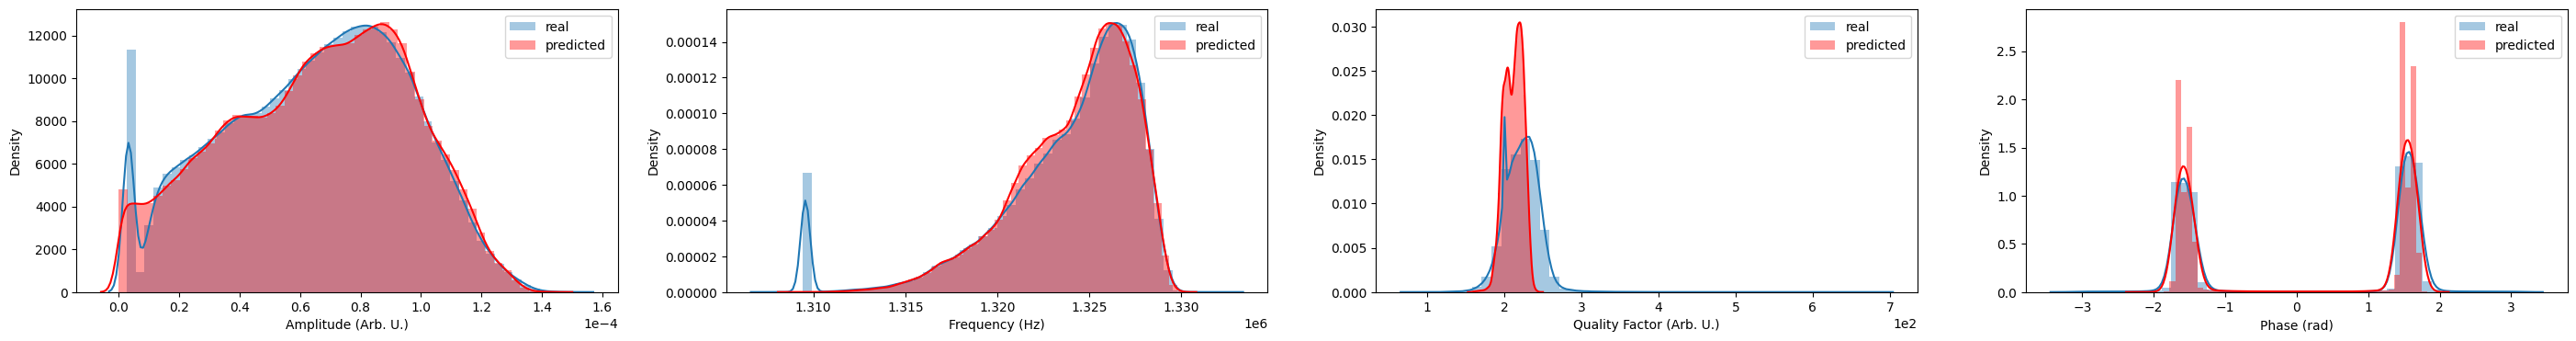

In [13]:
fig, axs = layout_fig(4, 4, figsize=(35, 4))

units = ['Amplitude (Arb. U.)', 'Frequency (Hz)', 'Quality Factor (Arb. U.)', 'Phase (rad)']

for i in range(4):
  sns.distplot(params_transformed[:, i].flatten(), ax=axs[i], label='real')
  sns.distplot(pred_params_transformed[:, i].flatten(), color='r', ax=axs[i], label='predicted')

i = 0
for ax in axs.flat:
    ax.set(xlabel=units[i], ylabel='Density')
    i+=1
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.legend()

### Visualize Best/Worst Results

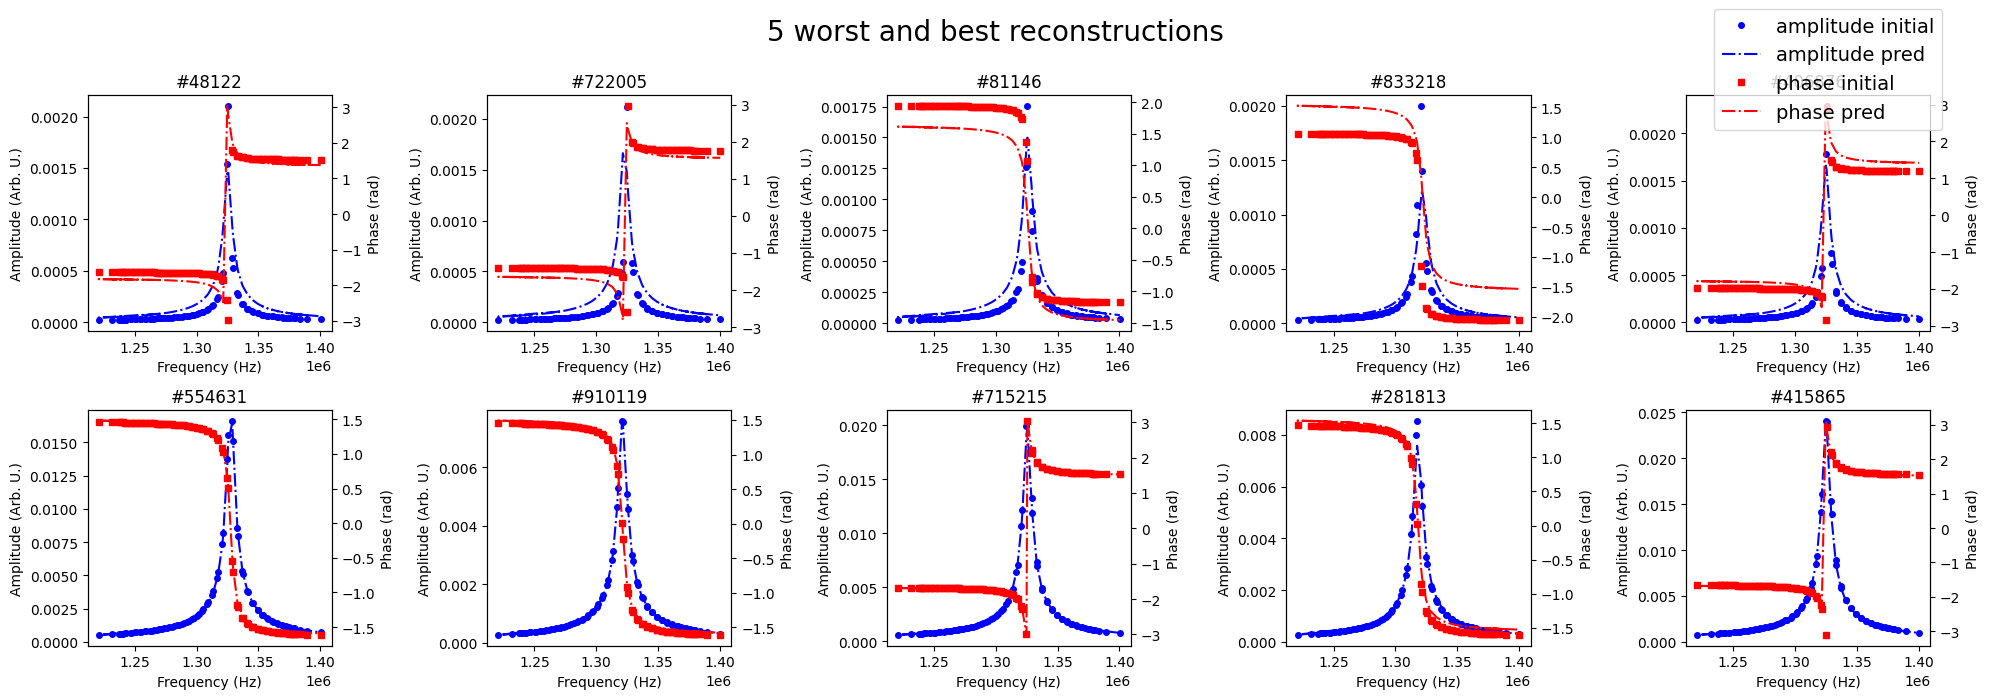

In [14]:
pred_params_copy_scaled = params_scaler.transform(pred_params_transformed)
params_copy_scaled = params_scaler.transform(params_transformed)

mse = np.mean(np.square(params_copy_scaled - pred_params_copy_scaled), 1)

# sorting by highest and lowest MSE
highest = (-mse).argsort()[:5]

fig, axs = plt.subplots(2, 5, figsize=(20, 7))
fig.suptitle('5 worst and best reconstructions', fontsize=20)

i = 0
for x in highest:
    out_real = SHO_fit_func_torch(torch.tensor(
        np.atleast_2d(params_transformed[x])), wvec_freq)
    out_pred = SHO_fit_func_torch(torch.tensor(
        np.atleast_2d(pred_params_transformed[x])), wvec_freq)
    
    magnitude_graph_real, phase_graph_real = convert_amp_phase(out_real)
    magnitude_graph_pred, phase_graph_pred = convert_amp_phase(out_pred)

    axs[0, i].plot(wvec_freq, magnitude_graph_real[0, :], 'o', markersize=4,
                        label='amplitude initial', color='b')
    axs[0, i].plot(wvec_freq, magnitude_graph_pred[0, :], '-.', label='amplitude pred', color='b')
    axs[0, i].set(xlabel='Frequency (Hz)', ylabel='Amplitude (Arb. U.)')
    ax1 = axs[0, i].twinx()
    ax1.plot(wvec_freq, phase_graph_real[0, :], 's', markersize=4,
                    label='phase initial', color='r')
    ax1.plot(wvec_freq, phase_graph_pred[0, :], '-.', label='phase pred', color='r')
    ax1.set_title("#" + str(x))
    ax1.set(xlabel='Frequency (Hz)', ylabel='Phase (rad)');

    if i == 0:
      lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
      lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    i += 1

for i in range(5):
    x = np.random.randint(0, params_transformed.shape[0])
    out_real = SHO_fit_func_torch(torch.tensor(
        np.atleast_2d(params_transformed[x])), wvec_freq)
    out_pred = SHO_fit_func_torch(torch.tensor(
        np.atleast_2d(pred_params_transformed[x])), wvec_freq)
    
    magnitude_graph_real, phase_graph_real = convert_amp_phase(out_real)
    magnitude_graph_pred, phase_graph_pred = convert_amp_phase(out_pred)

    axs[1, i].plot(wvec_freq, magnitude_graph_real[0, :], 'o', markersize=4,
                        label='amplitude initial', color='b')
    axs[1, i].plot(wvec_freq, magnitude_graph_pred[0, :], '-.', label='amplitude pred', color='b')
    axs[1, i].set(xlabel='Frequency (Hz)', ylabel='Amplitude (Arb. U.)')
    ax2 = axs[1, i].twinx()
    ax2.plot(wvec_freq, phase_graph_real[0, :], 's', markersize=4,
                    label='phase initial', color='r')
    ax2.plot(wvec_freq, phase_graph_pred[0, :], '-.', label='phase pred', color='r')
    ax2.set_title("#" + str(x))
    ax2.set(xlabel='Frequency (Hz)', ylabel='Phase (rad)');
    i += 1

    if i == 0:
      lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
      lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.tight_layout()
plt.legend(lines, labels, bbox_to_anchor=(1.05, 2.7), loc='upper right', borderaxespad=0., prop={'size': 14})
fig.subplots_adjust(top=0.87)

plt.savefig('Assets/Figures/best_and_worst_5_min_SHO_parameters.png', bbox_inches='tight')
plt.savefig('Assets/Figures/best_and_worst_5_min_SHO_parameters.svg', bbox_inches='tight')

## Computes the results on entire dataset

In [15]:
# prediction of parameters
batch_size = 10000
train_dataloader = DataLoader(scaled_data, batch_size=batch_size)

num_elements = len(train_dataloader.dataset)
num_batches = len(train_dataloader)
all_pred_params = torch.zeros_like(torch.tensor(params))

for i, train_batch in enumerate(train_dataloader):
  start = i*batch_size
  end = start + batch_size

  if i == num_batches - 1:
    end = num_elements

  pred_batch = model_parameters(train_batch.double().cuda())
  all_pred_params[start:end] = pred_batch.cpu().detach()

  del pred_batch
  del train_batch
  torch.cuda.empty_cache()

print(all_pred_params.shape)
all_pred_params = all_pred_params.cpu().detach().numpy()
print(all_pred_params.shape)

params_copy = np.copy(params)
all_pred_params_copy = np.copy(all_pred_params)

all_params_transformed, all_pred_params_transformed = transform_params(params_copy, all_pred_params_copy)

all_pred_params_scaled = params_scaler.transform(all_pred_params_transformed)
all_params_scaled = params_scaler.transform(all_params_transformed)

torch.Size([1382400, 4])
(1382400, 4)


### Saves the results in PyUSID format

In [15]:
all_pred_params_reshaped = np.reshape(all_pred_params, (num_pix, voltage_steps, -1))

amp = np.array(all_pred_params_reshaped[:, :, 0], dtype=[('Amplitude', 'float32')])
res = np.array(all_pred_params_reshaped[:, :, 1], dtype=[('Resonance', 'float32')])
qfc = np.array(all_pred_params_reshaped[:, :, 2], dtype=[('Q-Factor', 'float32')])
ph = np.array(all_pred_params_reshaped[:, :, 3], dtype=[('Phase', 'float32')])

params_list = rfn.merge_arrays((amp, res, qfc, ph), flatten = True, usemask = False)
params_list = params_list.reshape((num_pix, voltage_steps))

h5_results_grp = create_results_group(h5_f['Measurement_000']['Channel_000']['Raw_Data'], 'Predictions', h5_parent_group=h5_f['Measurement_000']['Channel_000'])

num_pix_1d = int(np.sqrt(num_pix))
pos_sizes = [num_pix_1d, num_pix_1d]
pos_names = ['X', 'Y']
pos_units = ['nm', 'um']
pos_dims = []
for length, name, units in zip(pos_sizes, pos_names, pos_units):
    pos_dims.append(Dimension(name, units, np.arange(length)))

spec_sizes = [voltage_steps]
spec_names = ['Cycle']
spec_units = ['V']
spec_dims = []
for length, name, units in zip(spec_sizes, spec_names, spec_units):
    spec_dims.append(Dimension(name, units, np.arange(length)))

write_main_dataset(h5_results_grp,
                    params_list, 'SHO-Pred-Results', 
                    '(Amplitude, Resonance, Q-Factor, Phase)', 
                    '(Arb. U., Frequency (Hz), Arb. U., rad)',
                    pos_dims, spec_dims)

c:\Users\abeke\anaconda3\envs\rapid_fitting\lib\site-packages\pyUSID\io\hdf_utils\model.py:831: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:SHO-Pred-Results to SHO_Pred_Results
  warn('main_data_name should not contain the "-" character. Reformatted name from:{} to '
c:\Users\abeke\anaconda3\envs\rapid_fitting\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1072: UserWarning: In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying
  warn('In the future write_ind_val_dsets will default to requiring dimensions to be arranged from slowest to fastest varying')
c:\Users\abeke\anaconda3\envs\rapid_fitting\lib\site-packages\pyUSID\io\hdf_utils\simple.py:1129: UserWarning: pyUSID.io.hdf_utils.simple.write_ind_val_dsets no longer createsregion references for each dimension. Please use pyUSID.io.reg_ref.write_region_references to manually create region references
  warn('pyUSID.io.hdf_utils.

<HDF5 dataset "SHO_Pred_Results": shape (3600, 384), type "|V16">
located at: 
	/Measurement_000/Channel_000/Raw_Data-Predictions_000/SHO_Pred_Results 
Data contains: 
	(Amplitude, Resonance, Q-Factor, Phase) ((Arb. U., Frequency (Hz), Arb. U., rad)) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 60 
	X - size: 60 
Spectroscopic Dimensions: 
	Cycle - size: 384
Data Fields:
	Amplitude, Resonance, Q-Factor, Phase

In [16]:
usid.hdf_utils.print_tree(h5_f)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Predictions_000
      ------------------------
      ├ Position_Indices
      ├ Position_Values
      ├ SHO_Pred_Results
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
      ├ scaled_fit
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
     

In [16]:
h5_f.close()